In [1]:
import os
import sys
dir_path = '/'.join(os.path.realpath('.').split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
import time
import random

import sglm
import sglm_cv
import sglm_pp
import sglm_ez
import sglm_plt as splt
import sglm_save as ssave
import lynne_pp as lpp
from tqdm import tqdm, trange

import cProfile
import pickle

from er_refactored_from_scratch import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
filename = 'Ach_rDAh_WT63_11082021.csv'


# Select hyper parameters for GLM to use for model selection
# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 0.9, 1.0],
    'l1_ratio': [0.0, 0.001, 0.1],

    # 'alpha': [0.001, 0.01,],
    # 'l1_ratio': [0.0, 0.001,],

    # 'alpha': [0.001,],
    # 'l1_ratio': [0.0,],
}

# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'max_iter': 1000,
    'fit_intercept': True
}
# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)


X_cols_all = [
    'nTrial',
    'cpn', 'cpx',
    'spnr', 'spxr',
    'spnnr', 'spxnr',
    'sl',
]


ssave_folder = 'model_outputs/ssave'
all_models_folder = 'model_outputs/all_models'
all_data_folder = 'model_outputs/all_data'
all_reconstruct_folder = 'model_outputs/all_reconstructions'
all_coeffs_folder = 'model_outputs/all_coeffs'
best_reconstruct_folder = 'model_outputs/best_reconstructions'
best_coeffs_folder = 'model_outputs/best_coeffs'

prefix = '88'
avg_reconstruct_basename = 'arr'
all_betas_basename = 'betas'
model_c_basename = 'coeffs'
model_i_basename = 'intercept'
tmp_data_basename = 'tmp_data'

score_method = 'r2'  

neg_order, pos_order = -14, 14
folds = 50
pholdout = 0.2
pgss = 0.2

res = {}

# leave_one_out_list = [[]]
leave_one_out_list = [[]] + [[_] for _ in X_cols_all]


In [4]:
# Load file
df = pd.read_csv(f'{dir_path}/../{filename}')
df = preprocess_lynne(df)
df['wi_trial_keep'] = get_is_not_iti(df)

Index(['time (msec)', 'center port entry', 'center port occupancy',
       'center port exit', 'left port entry', 'left port occupancy',
       'left port exit', 'left licks', 'right port entry',
       'right port occupancy', 'right port exit', 'right licks', 'no reward',
       'reward', 'raw uncorrected (Ach3.0)', 'raw uncorrected (rGRAB-DA)',
       'dF/F (Ach3.0)', 'dF/F (rGRAB-DA)', 'zscore dF/F (Ach3.0)',
       'zscore dF/F (rGRAB-DA)'],
      dtype='object')
Percent of Data in ITI: 0.536621082217341


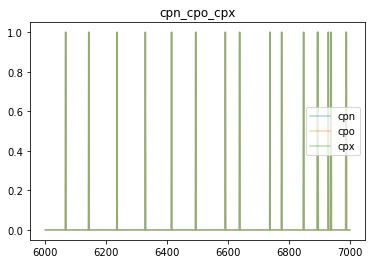

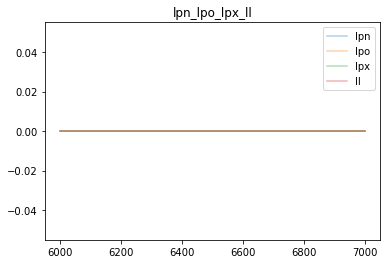

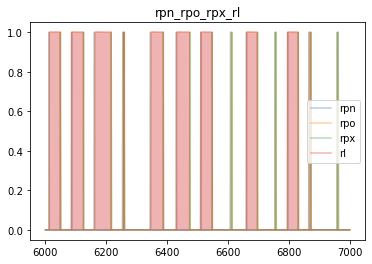

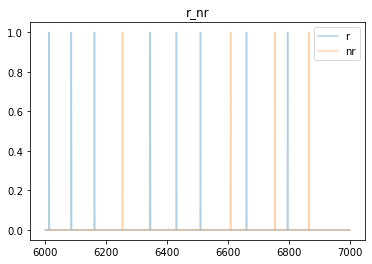

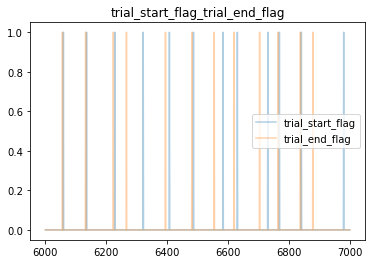

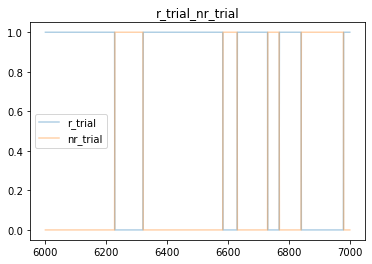

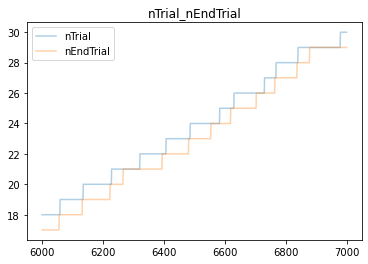

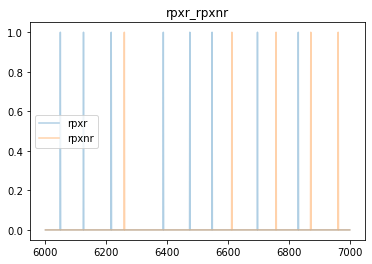

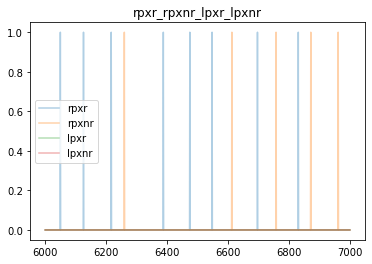

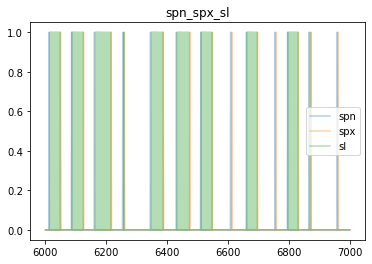

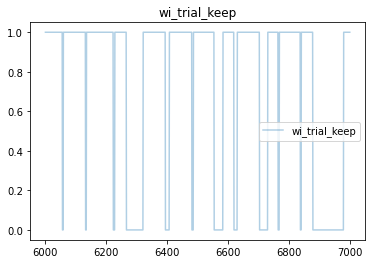

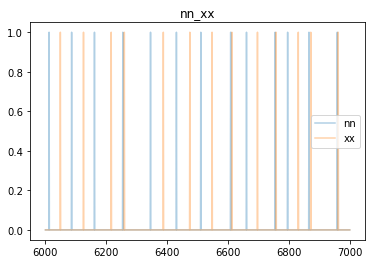

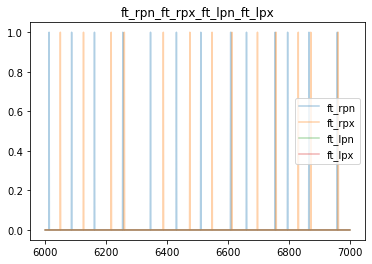

In [5]:
for col in [['cpn', 'cpo', 'cpx'], ['lpn', 'lpo', 'lpx', 'll'], ['rpn', 'rpo', 'rpx', 'rl'], ['r', 'nr'],
            ['trial_start_flag', 'trial_end_flag'], ['r_trial', 'nr_trial'], ['nTrial', 'nEndTrial'], ['rpxr', 'rpxnr'],
            ['rpxr', 'rpxnr', 'lpxr', 'lpxnr'], ['spn', 'spx', 'sl'], ['wi_trial_keep'], ['nn', 'xx'],
            ['ft_rpn', 'ft_rpx', 'ft_lpn', 'ft_lpx', ]
            ]:
    plt.figure()
    plt.title('_'.join(col))
    for one_col in col:
        plt.plot(df[one_col].iloc[6000:7000], label=one_col, alpha=0.35)
    plt.legend()

In [6]:
# def profile(df):
#     y_col = 'zsrdFF'
#     df = detrend(df, y_col)
#     fn = filename.split('.')[0].split('/')[-1]

#     left_out = ['spx']

#     X_cols = [_ for _ in X_cols_all if _ not in left_out]

#     if len(leave_one_out_list) > 1:
#         run_id = f'{prefix}_{fn}_{y_col}_drop={"_".join(left_out)}'
#     else:
#         run_id = f'{prefix}_{fn}_{y_col}'

#     print("Run ID:", run_id)
#     dfrel = df.copy()

# cProfile.run('profile(df)', sort='cumtime') # detrend takes ~1 minute to run


y_col = 'zsrdFF'
df = detrend(df, y_col)
fn = filename.split('.')[0].split('/')[-1]

left_out = ['spx']

X_cols = [_ for _ in X_cols_all if _ not in left_out]

if len(leave_one_out_list) > 1:
    run_id = f'{prefix}_{fn}_{y_col}_drop={"_".join(left_out)}'
else:
    run_id = f'{prefix}_{fn}_{y_col}'

print("Run ID:", run_id)
dfrel = df.copy()

Run ID: 88_Ach_rDAh_WT63_11082021_zsrdFF_drop=spx


PCA fit in 0.3145878314971924 seconds
> PCA-based Model fit in 0.12042093276977539 seconds
> PCA GLM Built in 0.49008631706237793 seconds
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.001, 'l1_ratio': 0.0}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.001, 'l1_ratio': 0.001}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.001, 'l1_ratio': 0.1}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.01, 'l1_ratio': 0.0}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.01, 'l1_ratio': 0.001}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.01, 'l1_ratio': 0.1}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.1, 'l1_ratio': 0.0}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.1, 'l1_ratio': 0.001}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.1, 'l1_ratio': 0.1}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.5, 'l1_ratio': 0.0}
{'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.5, 'l1_ratio': 0.001}
{'max_iter': 1000, 'fit_intercept': True, 

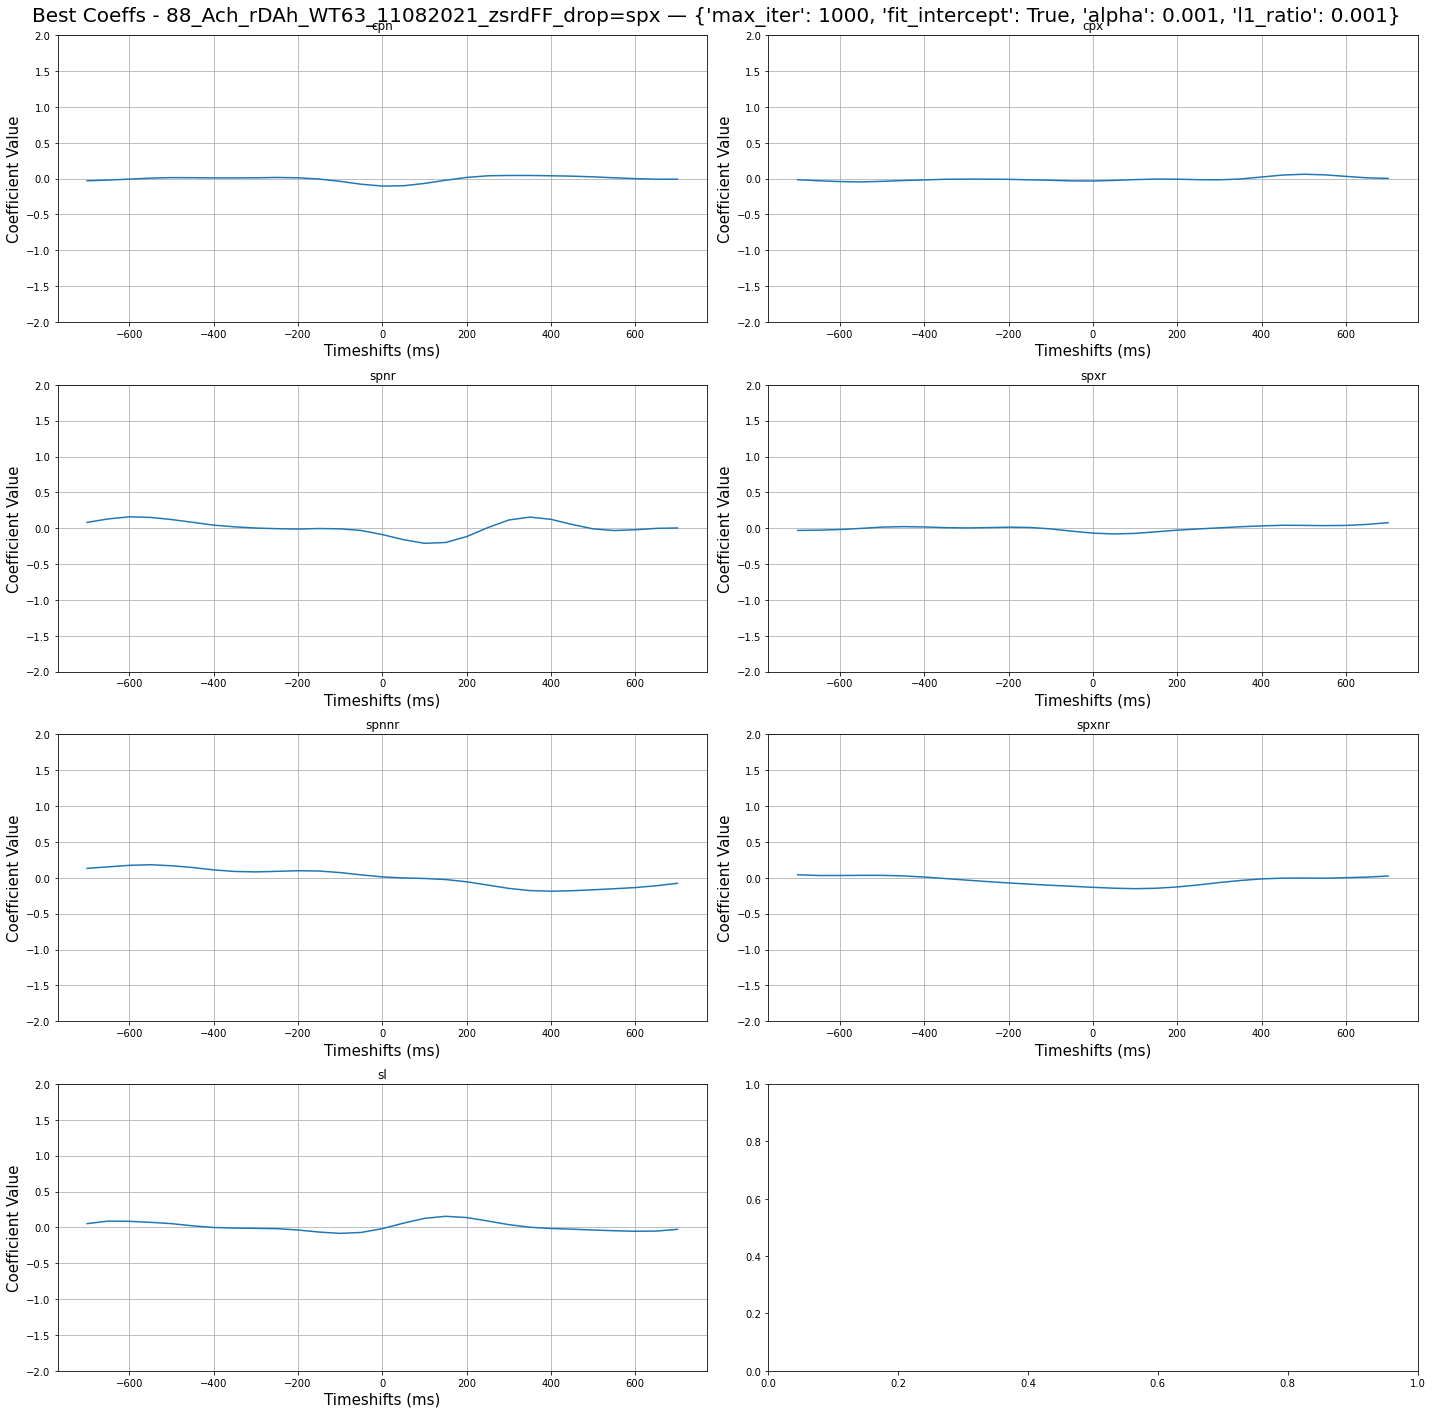

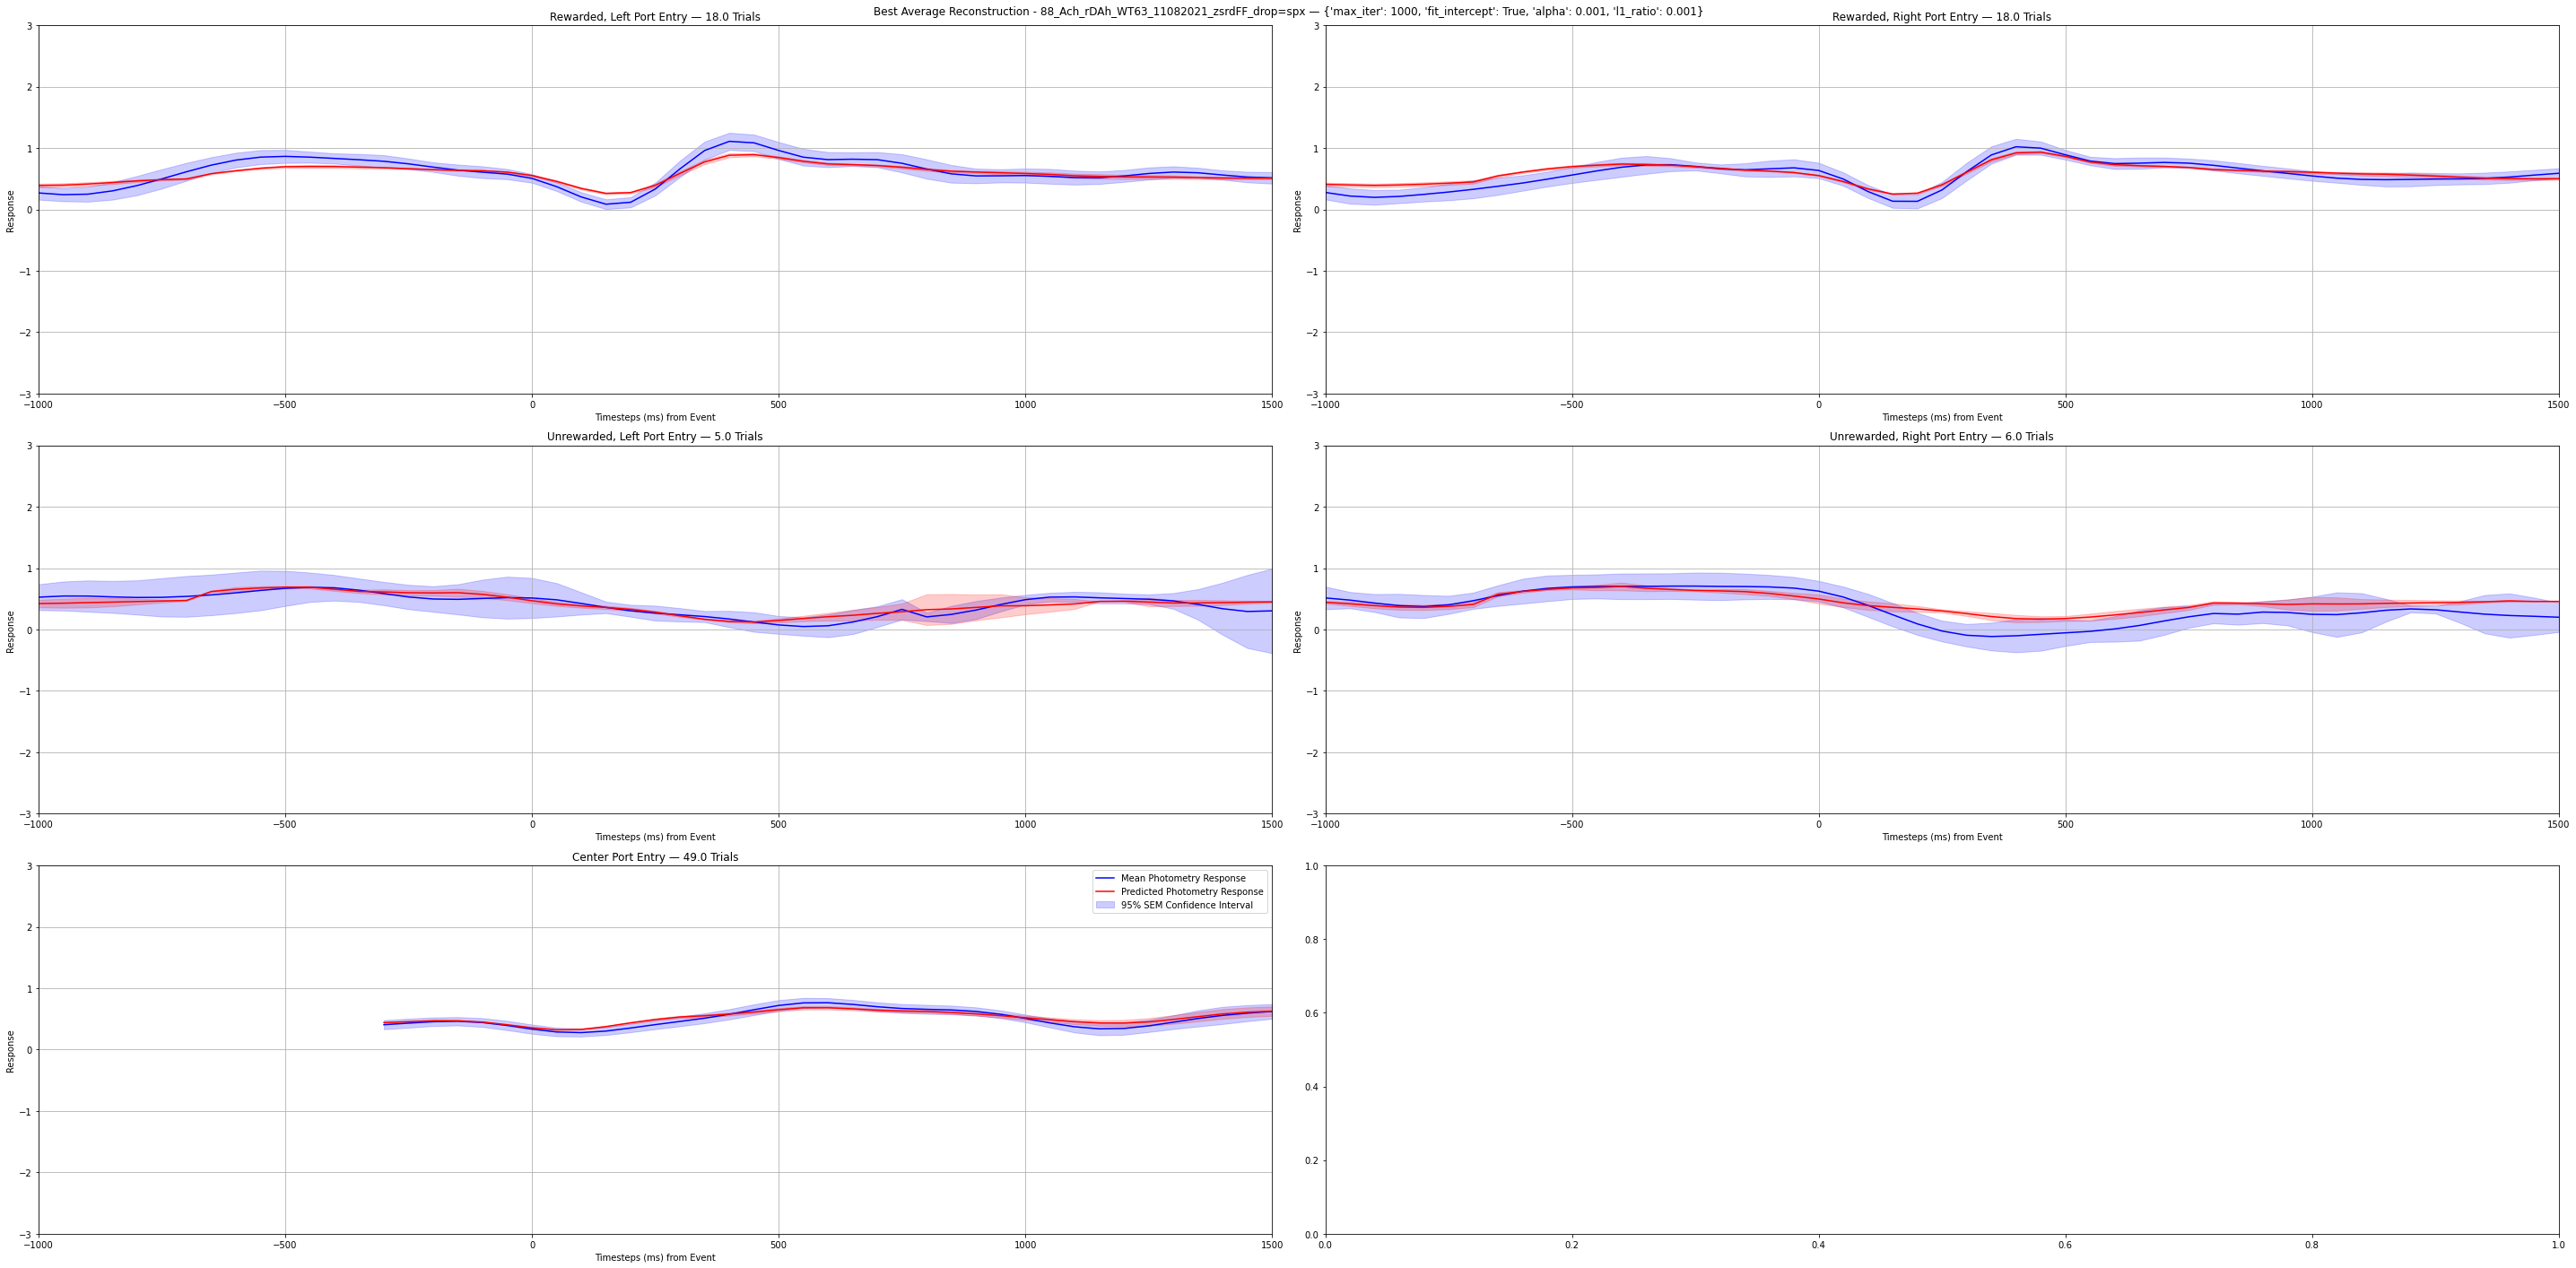

In [7]:
def profile(dfrel):
    start = time.time()

    # Timeshift X_cols forward by pos_order times and backward by neg_order times
    dfrel, X_cols_sftd = timeshift_vals(dfrel, X_cols, neg_order=neg_order, pos_order=pos_order)
    dfrel = dfrel.dropna()
    dfrel_setup, dfrel_holdout = holdout_splits(dfrel,
                                                id_cols=['nTrial'],
                                                perc_holdout=pholdout)

    # Generate cross-validation (technically, group / shuffle split) sets for training / model selection
    kfold_cv_idx = sglm_ez.cv_idx_by_trial_id(dfrel_setup,
                                            trial_id_columns=['nTrial'],
                                            num_folds=folds,
                                            test_size=pgss)

    prediction_X_cols = [_ for _ in X_cols if _ not in ['nTrial']]
    prediction_X_cols_sftd = [_ for _ in X_cols_sftd if _ not in ['nTrial']]

    X_setup = get_x(dfrel_setup, prediction_X_cols_sftd, keep_rows=None)
    y_setup = get_y(dfrel_setup, y_col, keep_rows=None)

    best_score, best_score_std, best_params, best_model, cv_results = sglm_ez.simple_cv_fit(X_setup, y_setup, kfold_cv_idx, glm_kwarg_lst, model_type='Normal', verbose=0, score_method=score_method)

    print_best_model_info(X_setup, best_score, best_params, best_model, start)

    X_holdout_witi = get_x(dfrel_holdout, prediction_X_cols_sftd, keep_rows=None)
    y_holdout_witi = get_y(dfrel_holdout, y_col, keep_rows=None)
    X_holdout_noiti = get_x(dfrel_holdout, prediction_X_cols_sftd, keep_rows=dfrel_holdout['wi_trial_keep'])
    y_holdout_noiti = get_y(dfrel_holdout, y_col, keep_rows=dfrel_holdout['wi_trial_keep'])
    glm, holdout_score, holdout_neg_mse_score = training_fit_holdout_score(X_setup, y_setup, X_holdout_noiti, y_holdout_noiti, best_params)

    # Collect
    res[f'{run_id}'] = {'holdout_score':holdout_score,
                                'holdout_neg_mse_score':holdout_neg_mse_score,
                                'best_score':best_score,
                                'best_params':best_params,
                                'all_models':sorted([(_['cv_R2_score'],
                                                        _['cv_mse_score'],
                                                        sglm_ez.calc_l1(_['cv_coefs']),
                                                        sglm_ez.calc_l2(_['cv_coefs']),
                                                        _['glm_kwargs']) for _ in cv_results['full_cv_results']], key=lambda x: -x[0])
                                }
    print(f'Holdout Score: {holdout_score}')

    # Generate and save plots of the beta coefficients
    X_cols_plot = prediction_X_cols
    X_cols_sftd_plot = prediction_X_cols_sftd


    holdout_score_rnd = np.round(holdout_score, 4)
    best_beta_fn = f'{best_coeffs_folder}/{run_id}_best_{all_betas_basename}_R2_{holdout_score_rnd}.png'
    splt.plot_all_beta_coefs(glm.coef_, X_cols_plot,
                                    X_cols_sftd_plot,
                                    plot_width=2,
                                    y_lims=(-2.0, 2.0),
                                    # filename=f'{fn}_coeffs.png',
                                    binsize=50,
                                    # filename=best_beta_fn,
                                    plot_name=f'Best Coeffs - {run_id} — {best_params}'
                                    )

    tmp = dfrel_holdout.set_index('nTrial').copy()
    tmp['pred'] = glm.predict(get_x(dfrel_holdout, prediction_X_cols_sftd))
    tmp = get_first_entry_time(tmp)


    best_beta_fn = f'{best_reconstruct_folder}/{run_id}_best_{avg_reconstruct_basename}_R2_{holdout_score_rnd}.png'
    splt.plot_avg_reconstructions(tmp,
                                y_col=y_col,
                                binsize = 50,
                                min_time = -20,
                                max_time = 30,
                                min_signal = -3.0,
                                max_signal = 3.0,
                                # file_name=best_beta_fn,
                                title=f'Best Average Reconstruction - {run_id} — {best_params}'
                                )

cProfile.run('profile(dfrel)', sort='cumtime') # detrend takes ~1 minute to run


In [11]:
num_files = 3
num_resp = 2
num_leaveouts = len(X_cols)

num_files*num_resp*num_leaveouts*8//60

6

In [9]:
import threading
import queue
q = queue.Queue()
def worker():
    while True:
        item = q.get()
        print(f'Working on {item}')
        print(f'Finished {item}')
        q.task_done()

threading.Thread(target=worker, daemon=True).start()

for item in range(30):
    q.put(item)
print('All task requests sent\n', end='')

q.join()
print('All work completed')

All task requests sent
Working on 0
Finished 0
Working on 1
Finished 1
Working on 2
Finished 2
Working on 3
Finished 3
Working on 4
Finished 4
Working on 5
Finished 5
Working on 6
Finished 6
Working on 7
Finished 7
Working on 8
Finished 8
Working on 9
Finished 9
Working on 10
Finished 10
Working on 11
Finished 11
Working on 12
Finished 12
Working on 13
Finished 13
Working on 14
Finished 14
Working on 15
Finished 15
Working on 16
Finished 16
Working on 17
Finished 17
Working on 18
Finished 18
Working on 19
Finished 19
Working on 20
Finished 20
Working on 21
Finished 21
Working on 22
Finished 22
Working on 23
Finished 23
Working on 24
Finished 24
Working on 25
Finished 25
Working on 26
Finished 26
Working on 27
Finished 27
Working on 28
Finished 28
Working on 29
Finished 29
All work completed
